In [ ]:
#a complete project flow that combines RFM Analysis, Clustering,
# Market Basket Analysis, Regression, and Classification — all in one Customer Analytics Project.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

# 1. Load Data
df = pd.read_csv("customer_data.csv")  # Include: InvoiceNo, Date, Amount, Product, CustomerID

# 2. Preprocess
df.dropna(subset=["CustomerID"], inplace=True)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Total"] = df["Quantity"] * df["UnitPrice"]

# 3. RFM Analysis
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "count",
    "Total": "sum"
}).rename(columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "Total": "Monetary"})

# 4. Clustering Customers
X = rfm[["Recency", "Frequency", "Monetary"]]
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(X)

# 5. Market Basket Analysis
basket = (df[df['Country'] == "Germany"]
         .groupby(['InvoiceNo', 'Description'])['Quantity']
         .sum().unstack().fillna(0))
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 6. Regression (e.g., Predict Monetary Value)
X_reg = rfm.drop(["Monetary", "Cluster"], axis=1)
y_reg = rfm["Monetary"]
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# 7. Classification (e.g., Predict High-Value Customer)
rfm["HighValue"] = (rfm["Monetary"] > rfm["Monetary"].median()).astype(int)
X_class = rfm.drop(["Monetary", "Cluster", "HighValue"], axis=1)
y_class = rfm["HighValue"]

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Optional: Save models or visualize in Streamlit


RMSE: 51.85174731393942
              precision    recall  f1-score   support

           0       0.50      0.82      0.62        11
           1       0.83      0.53      0.65        19

    accuracy                           0.63        30
   macro avg       0.67      0.67      0.63        30
weighted avg       0.71      0.63      0.64        30



C:\Users\hp\AppData\Local\Temp\ipykernel_20764\3913662565.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\hp\anaconda3\envs\pycaret-env\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\hp\anaconda3\envs\pycaret-env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2]:
# Create quantile-based bins for each metric
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

# Combine RFM score into a single value
rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)


In [ ]:
# Segment the Customers Based on RFM Score

In [3]:
def segment_customer(row):
    if row["RFM_Score"] == '555':
        return "Champion"
    elif row["R_Score"] == '5':
        return "Recent"
    elif row["F_Score"] == '5':
        return "Frequent"
    elif row["M_Score"] == '5':
        return "Big Spender"
    elif row["RFM_Score"].startswith('1'):
        return "At Risk"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)


In [4]:
rfm.to_csv("RFM_segments.csv")


C:\Users\hp\anaconda3\envs\pycaret-env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\hp\anaconda3\envs\pycaret-env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\hp\anaconda3\envs\pycaret-env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


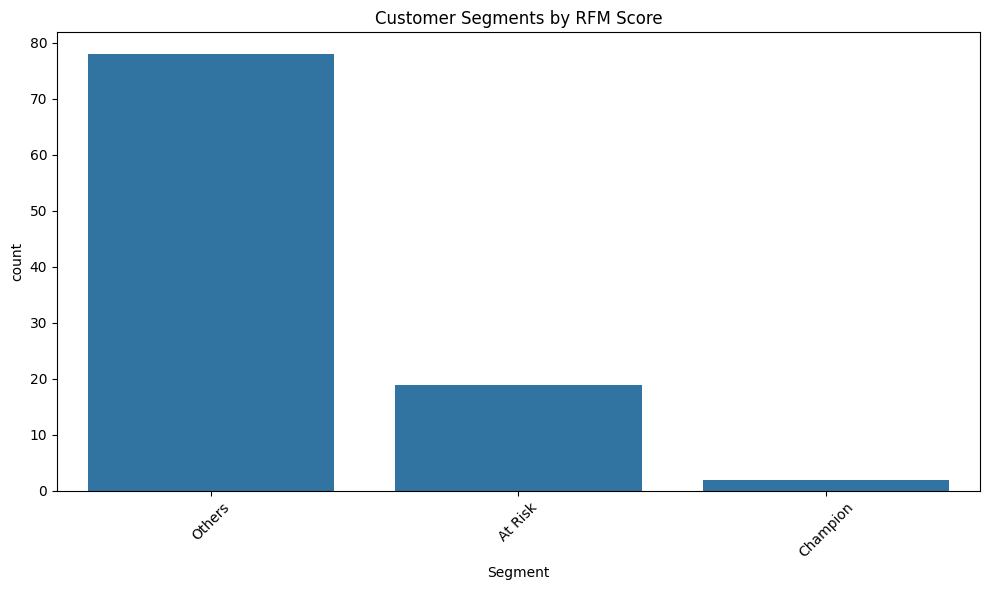

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index)
plt.title("Customer Segments by RFM Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
rfm.head()

,Recency,Frequency,Monetary,Cluster,HighValue,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,,,
10000,4,9,299.09,1,1,5,5,5,555,Champion
10001,74,10,234.70,1,1,3,5,5,355,Others
10002,10,7,273.40,1,1,5,4,5,545,Others
10003,128,5,169.71,3,1,2,3,4,234,Others
10004,41,3,94.56,0,0,3,1,2,312,Others
